# 🔐 **Project Title: _SentinelPay Financial Fraud Detection System_**

---

## 1. **Problem Definition** 🎯

> Given a set of financial transaction records enriched with cardholder and merchant information, can we predict **whether a transaction is fraudulent**?

This is a **binary classification** problem where the target variable (`is_fraud`) indicates whether a transaction is flagged as fraud (`1 = fraud`, `0 = legitimate`).

The goal is to build an end-to-end machine learning pipeline to:
- Detect fraudulent activities with high precision and recall  
- Reduce financial loss and protect customer assets  
- Support real-time fraud monitoring and flagging systems

---

## 2. **Data Overview** 📚

The dataset is compiled from a **financial institution's synthetic database** and includes five integrated sources:

| Dataset | Description |
|---------|-------------|
| `transactions_data.csv` | Records of all transactions with amounts, timestamps, merchants |
| `cards_dat.csv` | Details of debit/credit cards used in transactions |
| `mcc_codes.json` | Merchant category codes to classify business types |
| `train_fraud_labels.json` | Binary fraud labels per transaction (1 = fraud, 0 = not fraud) |
| `users_data` | Customer demographic and account metadata |

---

## 3. **Dataset Structure** 🧩

Each row in the merged dataset represents a **single transaction**.

### 🎯 **Target Variable**
- `is_fraud` — whether the transaction is fraudulent (1 = fraud, 0 = legitimate)

### 🧠 **Predictor Variables (Features)**

| Column Name               | Description |
|---------------------------|-------------|
| `transaction_amount`      | Monetary value of the transaction |
| `transaction_time`        | Timestamp of transaction |
| `merchant_id`             | Unique identifier of the merchant |
| `mcc_code`                | Merchant Category Code |
| `card_id`                 | Unique ID for the card used |
| `card_type`               | Debit or Credit |
| `card_limit`              | Credit limit of the card |
| `card_activation_date`    | Date the card was activated |
| `user_id`                 | ID of the cardholder |
| `user_age`                | Customer age |
| `user_income`             | Customer reported income |
| `account_tenure`          | Duration since account opening |

---

## 4. **Evaluation Metrics** 🔍

As this is a **fraud detection problem with class imbalance**, we will use:

- ✅ **ROC-AUC Score** — overall classification capability  
- ✅ **Precision / Recall / F1-score** — key for minimizing false positives and false negatives  
- ✅ **PR-AUC** — area under Precision-Recall curve  
- ✅ **Confusion Matrix** — diagnostic analysis  
- ✅ **Matthews Correlation Coefficient (MCC)** — robust metric for imbalance

---

## 5. **Feature Engineering** ⚙️

Advanced feature engineering will be applied:

- 📆 **Time-based features**: `hour_of_day`, `day_of_week`, `is_weekend`, `days_since_card_activated`  
- 🏪 **Merchant behavior**: frequency of transaction with same merchant, MCC risk level  
- 👥 **User activity**: number of transactions in last 24h/7d, avg. transaction size  
- 📊 **Card profile**: card utilization ratio = `txn_amt / card_limit`  
- ⚠️ **Fraud risk flags**: first-time merchant, transaction amount outlier, high-frequency burst  

---


## **Import packages and libraries**
we will need to import all the required and extensions

In [ ]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, recall_score, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.multioutput import MultiOutputClassifier
# Add 
from sklearn.metrics import classification_report, f1_score, hamming_loss, precision_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from dateutil.relativedelta import relativedelta
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier

# Print last updated
import time
import pickle
import warnings
from datetime import datetime
import joblib

import json

# Timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")
warnings.filterwarnings("ignore")

Notebook last run (end-to-end): 2025-09-20 15:33:58.920345


## **Load Data & Preparation**
There are many different kinds of ways to store data. The typical way of storing tabular data, data similar to what you'd see in an Excel file is in .csv format. .csv stands for comma separated values.

Pandas has a built-in function to read .csv files called read_csv() which takes the file pathname of your .csv file. You'll likely use this a lot.

In [ ]:
df_cards = pd.read_csv('../data/cards_data.csv')

In [ ]:
df_cards

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6141,5361,185,Amex,Credit,300609782832003,01/2024,663,YES,1,$6900,11/2000,2013,No
6142,2711,185,Visa,Credit,4718517475996018,01/2021,492,YES,2,$5700,04/2012,2012,No
6143,1305,1007,Mastercard,Credit,5929512204765914,08/2020,237,NO,2,$9200,02/2012,2012,No
6144,743,1110,Mastercard,Debit,5589768928167462,01/2020,630,YES,1,$28074,01/2020,2020,No


In [ ]:
df_transactions = pd.read_csv('../data/transactions_data.csv')

In [ ]:
df_transactions

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [ ]:
df_user_data = pd.read_csv('../data/users_data.csv')

In [ ]:
df_user_data

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,986,32,70,1987,7,Male,6577 Lexington Lane,40.65,-73.58,$23550,$48010,$87837,703,3
1996,1944,62,65,1957,11,Female,2 Elm Drive,38.95,-84.54,$24218,$49378,$104480,740,4
1997,185,47,67,1973,1,Female,276 Fifth Boulevard,40.66,-74.19,$15175,$30942,$71066,779,3
1998,1007,66,60,1954,2,Male,259 Valley Boulevard,40.24,-76.92,$25336,$54654,$27241,618,1


In [ ]:
df_mcc = pd.read_json("../Data/mcc_codes.json", orient="index")
df_mcc.reset_index(inplace=True)
df_mcc.columns = ["mcc_code", "description"]

In [ ]:
df_mcc

,mcc_code,description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees
...,...,...
104,7549,Towing Services
105,5941,Sporting Goods Stores
106,5722,Household Appliance Stores
107,3009,Fabricated Structural Metal Products


In [ ]:
with open("../Data/train_fraud_labels.json", "r") as f:
    fraud_labels = json.load(f)

In [ ]:
# ดึง dictionary ข้างใน 'target'
labels_dict = fraud_labels["target"]

# แปลงเป็น DataFrame
df_fraud = pd.DataFrame(list(labels_dict.items()), columns=["transaction_id", "is_fraud"])

# ถ้าอยากให้เป็น 0/1 (แทน 'No' / 'Yes')
df_fraud["is_fraud"] = df_fraud["is_fraud"].map({"No": 0, "Yes": 1})

df_fraud['transaction_id'] = df_fraud['transaction_id'].astype(int)

print(df_fraud.head())

   transaction_id  is_fraud
0        10649266         0
1        23410063         0
2         9316588         0
3        12478022         0
4         9558530         0


In [ ]:
# ======= Merge Tables =======
df = df_transactions.merge(df_fraud, left_on='id', right_on='transaction_id', how='inner')

In [ ]:
# ======= Merge Tables =======
df = df.merge(df_cards, left_on = 'card_id', right_on= 'id', how='left', suffixes=("", "_card"))

In [ ]:
# ======= Merge Tables =======
df = df.merge(df_user_data, left_on='client_id', right_on='id', how='left', suffixes=("", "_user"))

In [ ]:
# Drop unnecessary columns
drop_cols = ["mcc", "id_card", "client_id_card", "card_number", "cvv", "acc_open_date", "id_user","address"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

## **Data Exploration (exploratory data analysis or EDA)**

Once you've imported a dataset, the next step is to explore. There's no set way of doing this. But what you should be trying to do is become more and more familiar with the dataset.

Compare different columns to each other, compare them to the target variable. Refer back to your data dictionary and remind yourself of what different columns mean.

Your goal is to become a subject matter expert on the dataset you're working with. So if someone asks you a question about it, you can give them an explanation and when you start building models, you can sound check them to make sure they’re not performing too well (overfitting) or why they might be performing poorly (underfitting).

Since EDA has no real set methodology, the following is a short checklist list you might want to walk through:

1. What question(s) are you trying to solve (or prove wrong)?

2. What kind of data do you have and how do you treat different types?

3. What’s missing from the data and how do you deal with it?

4. Where are the outliers and why should you care about them?

5. How can you add, change or remove features to get more out of your data?

One of the quickest and easiest ways to check your data is with the head() function. Calling it on any dataframe will print the top 5 rows. tail() calls the bottom 5. You can also pass a number to them like head(10) to show the top 10 rows.

In [ ]:
# Let's check the top 5 rows of our dataframe
df.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_year,birth_month,gender,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,1989,7,Female,46.80,-100.76,$23679,$48277,$110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,1971,6,Male,40.80,-91.12,$18076,$36853,$112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,1970,4,Male,33.18,-117.29,$16894,$34449,$36540,686,3
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,1968,5,Male,38.86,-76.60,$33529,$68362,$96182,711,2
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,1972,12,Female,40.84,-73.87,$25537,$52065,$98613,828,5


In [ ]:
# And the top 10
df.head(10)

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_year,birth_month,gender,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,1989,7,Female,46.80,-100.76,$23679,$48277,$110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,1971,6,Male,40.80,-91.12,$18076,$36853,$112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,1970,4,Male,33.18,-117.29,$16894,$34449,$36540,686,3
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,1968,5,Male,38.86,-76.60,$33529,$68362,$96182,711,2
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,1972,12,Female,40.84,-73.87,$25537,$52065,$98613,828,5
5,7475335,2010-01-01 00:14:00,1684,2140,$26.46,Online Transaction,39021,ONLINE,NaN,NaN,...,1963,11,Male,36.34,-83.28,$13668,$27861,$108313,782,5
6,7475338,2010-01-01 00:23:00,554,3912,$3.51,Swipe Transaction,67570,Pearland,TX,77581.0,...,1960,8,Male,29.66,-95.04,$26170,$53357,$114266,690,5
7,7475339,2010-01-01 00:23:00,605,5061,$2.58,Swipe Transaction,75781,Brooklyn,NY,11210.0,...,1977,10,Male,40.64,-73.94,$23316,$47542,$2667,725,3
8,7475340,2010-01-01 00:26:00,1556,2972,$39.63,Swipe Transaction,59935,Beulah,ND,58523.0,...,1989,7,Female,46.80,-100.76,$23679,$48277,$110153,740,4
9,7475341,2010-01-01 00:27:00,1797,1127,$43.33,Swipe Transaction,33326,Kahului,HI,96732.0,...,1952,11,Male,37.71,-122.16,$24971,$30962,$15336,743,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     int64  
 1   date                   object 
 2   client_id              int64  
 3   card_id                int64  
 4   amount                 object 
 5   use_chip               object 
 6   merchant_id            int64  
 7   merchant_city          object 
 8   merchant_state         object 
 9   zip                    float64
 10  errors                 object 
 11  transaction_id         int32  
 12  is_fraud               int64  
 13  card_brand             object 
 14  card_type              object 
 15  expires                object 
 16  has_chip               object 
 17  num_cards_issued       int64  
 18  credit_limit           object 
 19  acct_open_date         object 
 20  year_pin_last_changed  int64  
 21  card_on_dark_web       object 
 22  current_age       

In [ ]:
df.is_fraud.value_counts()

is_fraud
0    8901631
1      13332
Name: count, dtype: int64

If you'd prefer these values in percentages, `value_counts()` takes a parameter, `normalize` which can be set to true.

In [ ]:
# Normalized value counts
df.is_fraud.value_counts(normalize=True) * 100

is_fraud
0    99.850454
1     0.149546
Name: proportion, dtype: float64

In [ ]:
df.isna().sum()

id                             0
date                           0
client_id                      0
card_id                        0
amount                         0
use_chip                       0
merchant_id                    0
merchant_city                  0
merchant_state           1047865
zip                      1107377
errors                   8773196
transaction_id                 0
is_fraud                       0
card_brand                     0
card_type                      0
expires                        0
has_chip                       0
num_cards_issued               0
credit_limit                   0
acct_open_date                 0
year_pin_last_changed          0
card_on_dark_web               0
current_age                    0
retirement_age                 0
birth_year                     0
birth_month                    0
gender                         0
latitude                       0
longitude                      0
per_capita_income              0
yearly_inc

In [ ]:
df

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,birth_year,birth_month,gender,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,1989,7,Female,46.80,-100.76,$23679,$48277,$110153,740,4
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,1971,6,Male,40.80,-91.12,$18076,$36853,$112139,834,5
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,1970,4,Male,33.18,-117.29,$16894,$34449,$36540,686,3
3,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,1968,5,Male,38.86,-76.60,$33529,$68362,$96182,711,2
4,7475333,2010-01-01 00:07:00,1807,165,$4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,1972,12,Female,40.84,-73.87,$25537,$52065,$98613,828,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914958,23761862,2019-10-31 23:54:00,672,5001,$12.93,Chip Transaction,47508,Cosby,TN,37722.0,...,1983,2,Male,35.81,-83.25,$11755,$23967,$3880,722,4
8914959,23761863,2019-10-31 23:54:00,1384,3723,$67.01,Chip Transaction,58136,Williamson,GA,30292.0,...,1946,1,Female,38.53,-90.00,$22545,$23011,$30510,721,3
8914960,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,...,1938,11,Female,34.02,-117.89,$22681,$33483,$196,698,5
8914961,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,...,1957,9,Male,43.06,-87.96,$9995,$20377,$12092,789,4


In [ ]:
# Function Clean Data
def Clean_Data(df):
    from datetime import datetime
    import re

    df = df.copy()

    # Drop duplicates
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Fill missing values
    df["merchant_state"] = df["merchant_state"].fillna("Unknown")
    df["zip"] = df["zip"].fillna("00000")
    df["errors"] = df["errors"].fillna('is_not_error')

    # Clean Outliers
    df = df[df["current_age"] <= 100]

    # Clean money fields (remove $ sign and convert to numeric)
    money_cols = ["amount","per_capita_income", "yearly_income", "total_debt", "credit_limit"]
    for col in money_cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace(r"[$,]", "", regex=True)
                .str.strip()
            )
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # ---- Feature Engineering ----
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["acct_open_date"] = pd.to_datetime(df["acct_open_date"], errors="coerce")
    df["expires"] = pd.to_datetime(df["expires"], errors="coerce")

    # Filter date >= 2020-01-01
    df = df[df["date"] >= "2018-06-01"]

    # Time features
    df["txn_hour"] = df["date"].dt.hour
    df["txn_dayofweek"] = df["date"].dt.dayofweek

    # Account tenure
    df["account_tenure_days"] = (df["date"] - df["acct_open_date"]).dt.days

    # Days Since pin change
    df["days_since_pin_change"] = df["date"].dt.year - df["year_pin_last_changed"]

    # Days to expire
    df["days_to_expire"] = (df["expires"] - df["date"]).dt.days

    # Card utilization
    df["card_utilization"] = df["amount"] / (df["credit_limit"] + 1)  # Add 1 to avoid division by zero

    # Income to debt ratio
    df["income_to_debt_ratio"] = df["yearly_income"] / (df["total_debt"] + 1)  # Add 1 to avoid division by zero

    # Errors flag
    df["has_errors"] = (df["errors"] != "is_not_error").astype(int)

    # Age bucket
    df["age_bucket"] = pd.cut(df["current_age"], bins=[0, 25, 40, 60, 100], labels=["<25", "25-40", "40-60", "60-100"])   

    # Drop Columns not useful
    drop_cols = [
        "id",
        "transaction_id",
        "client_id",
        "card_id",
        "merchant_id",
        "date",                # kept engineered time features
        "expires",             # replaced with days_to_expire
        "year_pin_last_change",# replaced with days_since_pin_change
        "acct_open_date",      # replaced with acct_tenure_days
        "errors",              # replaced with has_error
        "birth_year",
        "birth_month",
        "retirement_age",
        "per_capita_income",
        "num_credit_card"      # typo/duplicate of num_credit_cards
    ]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    return df

In [ ]:
df_cleaned_use = Clean_Data(df)

In [ ]:
df_cleaned_use.head(5)

,amount,use_chip,merchant_city,merchant_state,zip,is_fraud,card_brand,card_type,has_chip,num_cards_issued,...,num_credit_cards,txn_hour,txn_dayofweek,account_tenure_days,days_since_pin_change,days_to_expire,card_utilization,income_to_debt_ratio,has_errors,age_bucket
7203025,69.21,Chip Transaction,La Habra,CA,90631.0,0,Visa,Credit,YES,2,...,3,0,0,1218,4,2281,0.011729,0.601750,0,40-60
7203026,140.00,Swipe Transaction,Crown Point,IN,46307.0,0,Visa,Credit,YES,1,...,5,0,0,2710,8,1856,0.010447,0.414604,0,40-60
7203027,114.18,Chip Transaction,Columbus,OH,43228.0,0,Mastercard,Debit,YES,1,...,6,0,0,3014,9,1580,0.005179,37556.000000,0,60-100
7203028,36.27,Chip Transaction,Panama City,FL,32401.0,0,Visa,Debit (Prepaid),YES,2,...,2,0,0,2891,8,1126,0.525652,0.471283,0,25-40
7203029,5.10,Chip Transaction,Hawthorne,CA,90250.0,0,Visa,Debit (Prepaid),YES,2,...,4,0,0,3409,10,1154,0.242857,0.592937,0,40-60


In [ ]:
df_cleaned_use.isna().sum()

amount                   0
use_chip                 0
merchant_city            0
merchant_state           0
zip                      0
is_fraud                 0
card_brand               0
card_type                0
has_chip                 0
num_cards_issued         0
credit_limit             0
year_pin_last_changed    0
card_on_dark_web         0
current_age              0
gender                   0
latitude                 0
longitude                0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
txn_hour                 0
txn_dayofweek            0
account_tenure_days      0
days_since_pin_change    0
days_to_expire           0
card_utilization         0
income_to_debt_ratio     0
has_errors               0
age_bucket               0
dtype: int64

In [ ]:
# Normalized value counts
df.is_fraud.value_counts(normalize=True) * 100

is_fraud
0    99.850454
1     0.149546
Name: proportion, dtype: float64

In [ ]:
df_cleaned_use

,amount,use_chip,merchant_city,merchant_state,zip,is_fraud,card_brand,card_type,has_chip,num_cards_issued,...,num_credit_cards,txn_hour,txn_dayofweek,account_tenure_days,days_since_pin_change,days_to_expire,card_utilization,income_to_debt_ratio,has_errors,age_bucket
7203025,69.21,Chip Transaction,La Habra,CA,90631.0,0,Visa,Credit,YES,2,...,3,0,0,1218,4,2281,0.011729,0.601750,0,40-60
7203026,140.00,Swipe Transaction,Crown Point,IN,46307.0,0,Visa,Credit,YES,1,...,5,0,0,2710,8,1856,0.010447,0.414604,0,40-60
7203027,114.18,Chip Transaction,Columbus,OH,43228.0,0,Mastercard,Debit,YES,1,...,6,0,0,3014,9,1580,0.005179,37556.000000,0,60-100
7203028,36.27,Chip Transaction,Panama City,FL,32401.0,0,Visa,Debit (Prepaid),YES,2,...,2,0,0,2891,8,1126,0.525652,0.471283,0,25-40
7203029,5.10,Chip Transaction,Hawthorne,CA,90250.0,0,Visa,Debit (Prepaid),YES,2,...,4,0,0,3409,10,1154,0.242857,0.592937,0,40-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8914958,12.93,Chip Transaction,Cosby,TN,37722.0,0,Visa,Debit,YES,1,...,4,23,3,5874,12,61,0.001551,6.175470,0,25-40
8914959,67.01,Chip Transaction,Williamson,GA,30292.0,0,Visa,Debit,YES,2,...,3,23,3,5600,13,92,0.002722,0.754187,0,60-100
8914960,1.11,Chip Transaction,West Covina,CA,91792.0,0,Mastercard,Debit,YES,1,...,5,23,3,244,0,92,0.000042,169.964467,0,60-100
8914961,12.80,Online Transaction,ONLINE,Unknown,00000,0,Mastercard,Debit,YES,1,...,4,23,3,5722,7,1674,0.002489,1.685024,0,60-100


#### **Save Process Data**

In [ ]:
# Save preprocessed data
df_cleaned_use.to_csv('../Data/df_processed_data.csv', index=False)

In [ ]:
df_cleaned_use = pd.read_csv('../data/df_processed_data.csv', low_memory=False)

### **Correlation between independent variables**

Finally, we'll compare all of the independent variables in one hit.

Why?

Because this may give an idea of which independent variables may or may not have an impact on our target variable.

We can do this using `df.corr()` which will create a [**correlation matrix**](https://www.statisticshowto.datasciencecentral.com/correlation-matrix/) for us, in other words, a big table of numbers telling us how related each variable is the other.

Text(0.5, 1.0, 'Correlation Heatmap in Employee Data')

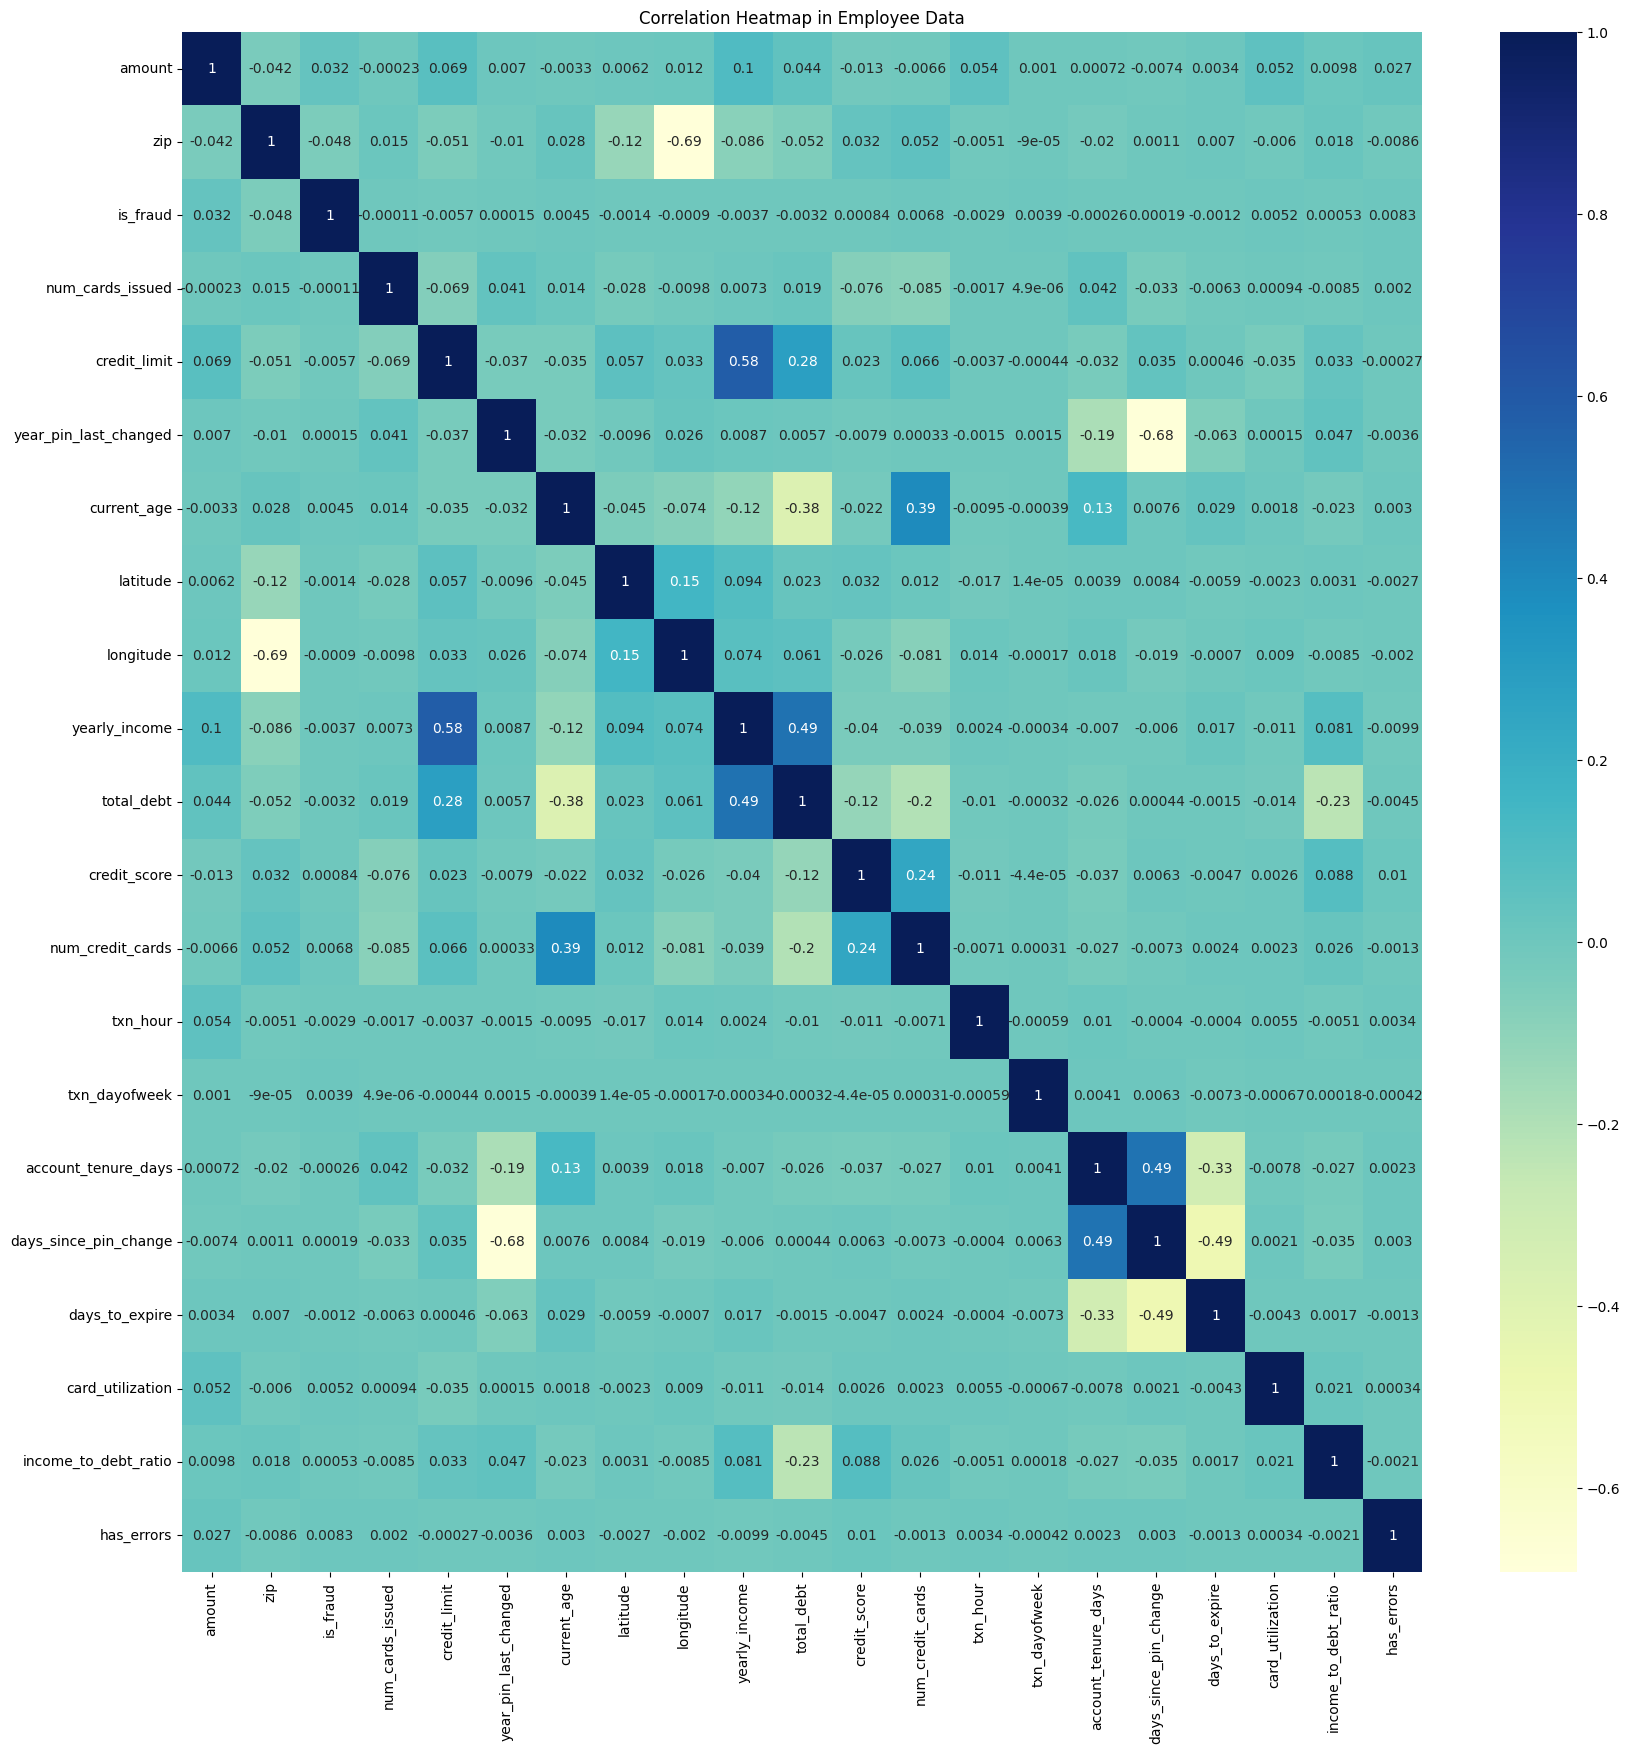

In [ ]:
# Find the correlation between our independent variables
numeric_columns = df_cleaned_use.select_dtypes(include=['int64', 'float64'])
correlations = numeric_columns.corr()
custom_cmap = "YlGnBu"
f, ax = plt.subplots(figsize = (20,20))
sns.heatmap(correlations, annot=True, cmap = custom_cmap)
ax.set_title('Correlation Heatmap in Employee Data') 

### **Check missing values**

In [ ]:
print("🔸 Missing Values per Column:")
print(df_cleaned_use.isnull().sum())


duplicate_rows = df_cleaned_use[df_cleaned_use.duplicated()]
print(f"\n🔸 Duplicate Rows (exact match): {len(duplicate_rows)}")

🔸 Missing Values per Column:
amount                   0
use_chip                 0
merchant_city            0
merchant_state           0
zip                      0
is_fraud                 0
card_brand               0
card_type                0
has_chip                 0
num_cards_issued         0
credit_limit             0
year_pin_last_changed    0
card_on_dark_web         0
current_age              0
gender                   0
latitude                 0
longitude                0
yearly_income            0
total_debt               0
credit_score             0
num_credit_cards         0
txn_hour                 0
txn_dayofweek            0
account_tenure_days      0
days_since_pin_change    0
days_to_expire           0
card_utilization         0
income_to_debt_ratio     0
has_errors               0
age_bucket               0
dtype: int64

🔸 Duplicate Rows (exact match): 4966


### **Check outliers**

In [ ]:
# เลือกเฉพาะคอลัมน์ตัวเลข
numeric_cols = df_cleaned_use.select_dtypes(include='number').columns

# ฟังก์ชันตรวจสอบ outliers ด้วย IQR
def detect_outliers_iqr(df_cleaned_use, columns):
    outlier_indices = {}
    for col in columns:
        Q1 = df_cleaned_use[col].quantile(0.25)
        Q3 = df_cleaned_use[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_cleaned_use[(df_cleaned_use[col] < lower_bound) | (df_cleaned_use[col] > upper_bound)]
        outlier_indices[col] = outliers.index.tolist()
        print(f"🔸 {col}: {len(outliers)} outliers")
    return outlier_indices

# เรียกใช้ฟังก์ชัน
outlier_dict = detect_outliers_iqr(df_cleaned_use, numeric_cols)

🔸 amount: 704823 outliers
🔸 zip: 0 outliers
🔸 is_fraud: 13324 outliers
🔸 num_cards_issued: 0 outliers
🔸 credit_limit: 305977 outliers
🔸 year_pin_last_changed: 417022 outliers
🔸 current_age: 50973 outliers
🔸 latitude: 48650 outliers
🔸 longitude: 83666 outliers
🔸 yearly_income: 500473 outliers
🔸 total_debt: 195577 outliers
🔸 credit_score: 294994 outliers
🔸 num_credit_cards: 16064 outliers
🔸 txn_hour: 0 outliers
🔸 txn_dayofweek: 0 outliers
🔸 account_tenure_days: 70466 outliers
🔸 days_since_pin_change: 108644 outliers
🔸 days_to_expire: 0 outliers
🔸 card_utilization: 1287031 outliers
🔸 income_to_debt_ratio: 1632428 outliers
🔸 has_errors: 141199 outliers


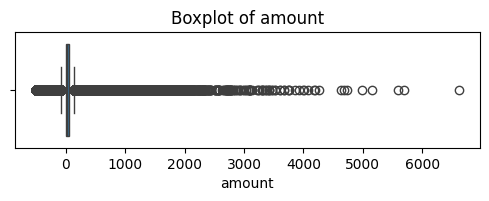

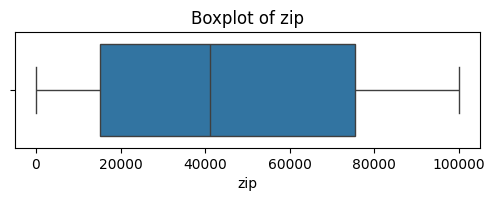

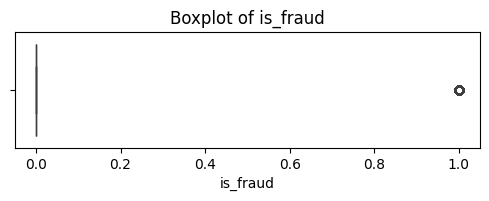

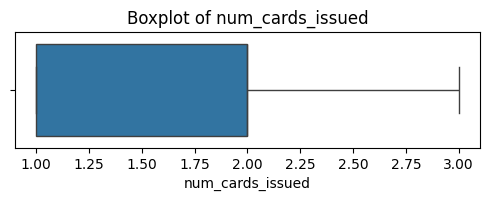

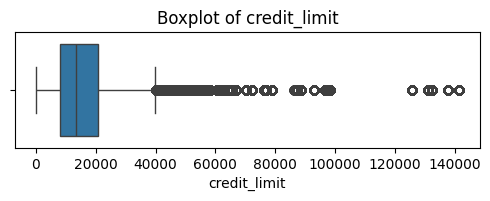

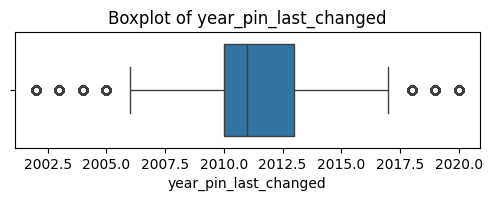

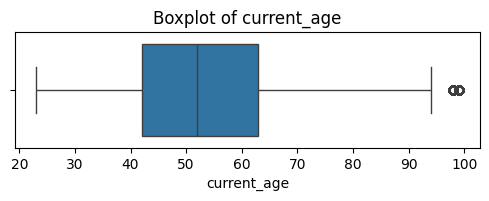

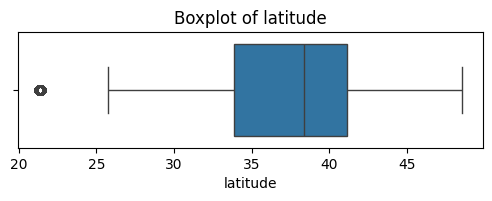

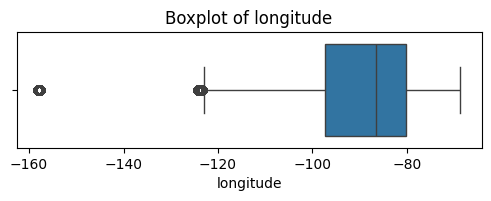

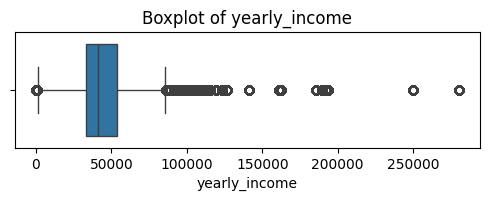

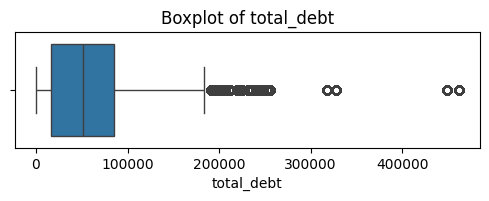

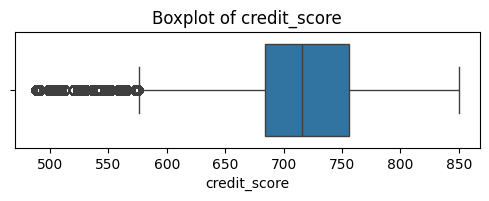

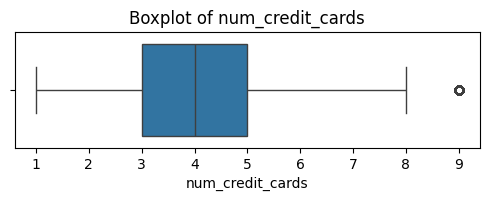

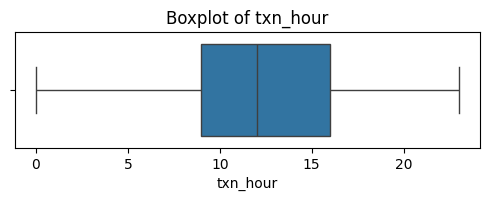

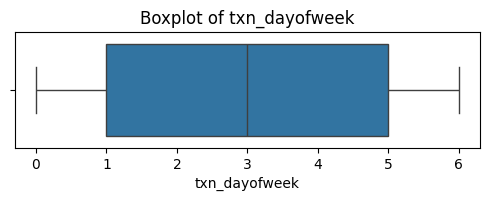

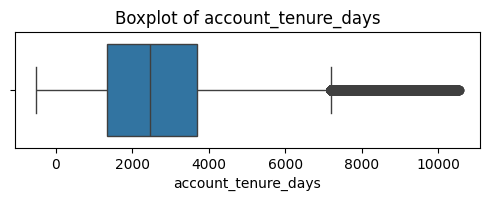

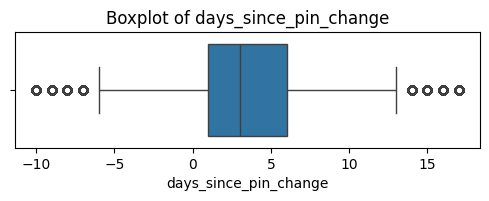

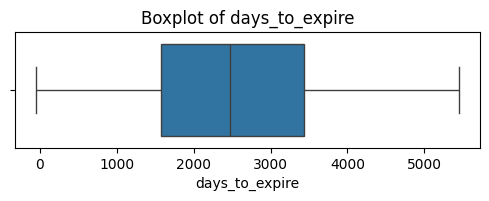

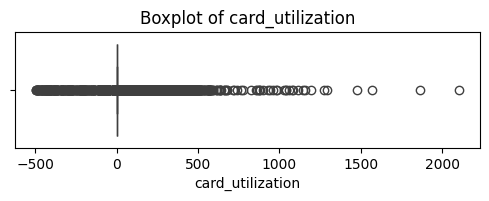

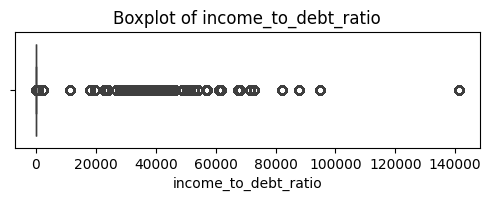

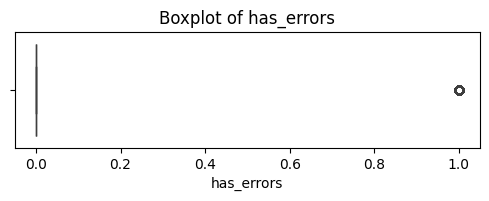

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# วาด Boxplot สำหรับแต่ละคอลัมน์ตัวเลข
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df_cleaned_use[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [ ]:
df_cleaned_use

,amount,use_chip,merchant_city,merchant_state,zip,is_fraud,card_brand,card_type,has_chip,num_cards_issued,...,num_credit_cards,txn_hour,txn_dayofweek,account_tenure_days,days_since_pin_change,days_to_expire,card_utilization,income_to_debt_ratio,has_errors,age_bucket
0,69.21,Chip Transaction,La Habra,CA,90631.0,0,Visa,Credit,YES,2,...,3,0,0,1218,4,2281,0.011729,0.601750,0,40-60
1,140.00,Swipe Transaction,Crown Point,IN,46307.0,0,Visa,Credit,YES,1,...,5,0,0,2710,8,1856,0.010447,0.414604,0,40-60
2,114.18,Chip Transaction,Columbus,OH,43228.0,0,Mastercard,Debit,YES,1,...,6,0,0,3014,9,1580,0.005179,37556.000000,0,60-100
3,36.27,Chip Transaction,Panama City,FL,32401.0,0,Visa,Debit (Prepaid),YES,2,...,2,0,0,2891,8,1126,0.525652,0.471283,0,25-40
4,5.10,Chip Transaction,Hawthorne,CA,90250.0,0,Visa,Debit (Prepaid),YES,2,...,4,0,0,3409,10,1154,0.242857,0.592937,0,40-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710060,12.93,Chip Transaction,Cosby,TN,37722.0,0,Visa,Debit,YES,1,...,4,23,3,5874,12,61,0.001551,6.175470,0,25-40
1710061,67.01,Chip Transaction,Williamson,GA,30292.0,0,Visa,Debit,YES,2,...,3,23,3,5600,13,92,0.002722,0.754187,0,60-100
1710062,1.11,Chip Transaction,West Covina,CA,91792.0,0,Mastercard,Debit,YES,1,...,5,23,3,244,0,92,0.000042,169.964467,0,60-100
1710063,12.80,Online Transaction,ONLINE,Unknown,0.0,0,Mastercard,Debit,YES,1,...,4,23,3,5722,7,1674,0.002489,1.685024,0,60-100


## **Split the data**
Assign target variable.

**Exemplar response:**
In this case, the target variable is `is_fraud`.
* 0 represents an no fraud
* 1 represents a fraud

In [ ]:
# Isolate target variable
y = df_cleaned_use['is_fraud']
X = df_cleaned_use.drop(columns=["is_fraud"], errors="ignore")

## **Create train/validate/test sets**

Split data into training and testing sets, 80/20.

In [ ]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Split the training set into training and validation sets, 75/25, to result in a final ratio of 60/20/20 for train/validate/test sets.

In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [ ]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1026039, 8590),
 (342013, 8590),
 (342013, 8590),
 (1026039,),
 (342013,),
 (342013,))

## **Feature selection and transformation**
Encode target and catgorical variables.

## **Modeling**

We've explored the data, now we'll try to use machine learning to predict our target variable based on the 13 independent variables.

Remember our problem?

> Given clinical parameters about a patient, can we predict whether or not they have heart disease?

That's what we'll be trying to answer.

And remember our evaluation metric?

> If we can reach 95% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursure this project.

That's what we'll be aiming for.

But before we build a model, we have to get our dataset ready.

Let's look at it again.

### **Build a random forest model**
Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall. 

In [ ]:
# RandomForest + class_weight balanced
rf = RandomForestClassifier(random_state=0, class_weight="balanced")

# Hyperparameters for tuning
cv_params = {
    'max_depth': [5, 7, None],
    'max_features': [0.3, 0.6],
    'max_samples': [0.7],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [75, 100, 200],
}

# Multiple scoring metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# GridSearchCV
rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    cv=5,
    refit='recall',   # ใช้ recall เป็น metric หลัก
    n_jobs=-1,
    verbose=2
)

In [ ]:
rf_cv.fit(X_train, y_train)

### **Build a random forest model**
Fit a random forest model to the training set. Use cross-validation to tune the hyperparameters and select the model that performs best on recall. 